<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [31]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [32]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


<AxesSubplot: >

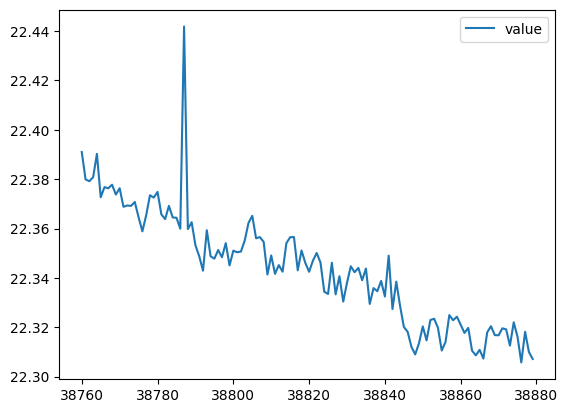

In [33]:
data[-120:].plot()

In [34]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [35]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [36]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [37]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [38]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [39]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [40]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [41]:
torch.manual_seed(42)

In [42]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 1.730899451632728 %
smape 0.7817947361631896 %
smape 0.22311268923382072 %
smape 0.1931416164717381 %
smape 0.15971945155015738 %
smape 0.1396035490767235 %
smape 0.172991713776855 %
smape 0.1609326212456564 %
smape 0.13520920807625064 %
smape 0.11624608957140614 %
smape 0.13967421808728012 %
smape 0.1505787407656674 %
smape 0.12195330960076978 %
smape 0.10910786303510475 %
smape 0.10184253465720557 %
smape 0.0871606550740394 %
smape 0.09618694759729694 %
smape 0.09182418318232521 %
smape 0.07910857566500257 %
smape 0.08032117635678848 %
smape 0.06437757992654038 %
smape 0.0718829339698273 %
smape 0.06703325655523752 %
smape 0.06514011993895323 %
smape 0.06185098453520181 %
smape 0.058562832643490347 %
smape 0.05823718707284166 %
smape 0.05712475978098102 %
smape 0.05728909079317679 %
smape 0.057095311400317185 %
smape 0.05534253005559246 %
smape 0.054198812736928115 %
smape 0.05316053015759966 %
smape 0.05256186246229281 %
smape 0.05216699888574352 %
smape 0.05164413320272344 %


In [43]:
torch.manual_seed(42)

In [44]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [45]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.012786088821940211 %
SMAPE 0.0019575515259191434 %
SMAPE 0.0054978053426566476 %
SMAPE 0.0013554662977099952 %
SMAPE 0.010492472512453332 %
SMAPE 0.013324882300622676 %
SMAPE 0.02685371903817213 %
SMAPE 0.024558875815230866 %
SMAPE 0.010479943101422862 %
SMAPE 0.003165574627132628 %
SMAPE 0.008751892678006357 %
SMAPE 0.023156306597115872 %
SMAPE 0.023684041167712166 %
SMAPE 0.022088039081722854 %
SMAPE 0.005888533521066108 %
SMAPE 0.007055584309426876 %
SMAPE 0.0010913775052472374 %
SMAPE 0.02836287563445694 %
SMAPE 0.004339578225469154 %
SMAPE 0.008839407413972822 %
SMAPE 0.006397079962042085 %
SMAPE 0.018592519771800653 %
SMAPE 0.09882713638296536 %
SMAPE 0.011099164702386588 %
SMAPE 0.021569340415283023 %
SMAPE 0.016434278089832333 %
SMAPE 0.0030194491739052864 %
SMAPE 0.015434799496745201 %
SMAPE 0.12760718271329097 %
SMAPE 0.019203147284713395 %
SMAPE 0.007833601915223198 %
SMAPE 0.008085969989664932 %
SMAPE 0.0008034168299673183 %
SMAPE 0.05076749478155307 %
SMAPE 0.01117

SMAPE 0.036675747456229146 %
SMAPE 0.02713287903731043 %
SMAPE 0.015665992082574576 %
SMAPE 0.026805096460066128 %
SMAPE 0.009004228536745984 %
SMAPE 0.001776705007870305 %
SMAPE 0.023105482646769815 %
SMAPE 0.005589626528973213 %
SMAPE 0.008287926396278067 %
SMAPE 0.0023256910794344776 %
SMAPE 0.0070295850861157305 %
SMAPE 0.00211389332481815 %
SMAPE 0.0046668779117098325 %
SMAPE 0.003734242698854473 %
SMAPE 0.0027532701062682463 %
SMAPE 0.011711351350328414 %
SMAPE 0.00671278215941129 %
SMAPE 0.002402327522105452 %
SMAPE 0.001163051565299611 %
SMAPE 0.0005164573185538757 %
SMAPE 0.008161971323410455 %
SMAPE 0.014843806921781777 %
SMAPE 0.004234880687562281 %
SMAPE 0.015462466835685973 %
SMAPE 0.008003589192384197 %
SMAPE 0.0034747002000656835 %
SMAPE 0.0064712227116956456 %
SMAPE 0.01416292566035082 %
SMAPE 0.008429673365810686 %
SMAPE 0.014336112984352667 %
SMAPE 0.024396976567459205 %
SMAPE 0.007027117446796183 %
SMAPE 0.002560686907031595 %
SMAPE 0.04724027463305447 %
SMAPE 0.0133

SMAPE 0.004071530191929185 %
SMAPE 0.00017360586628711872 %
SMAPE 0.020410908045050746 %
SMAPE 0.019370906573044522 %
SMAPE 0.01271208448520156 %
SMAPE 0.02716399327277941 %
SMAPE 0.0050892996784455136 %
SMAPE 0.02175504626285374 %
SMAPE 0.020195150428065745 %
SMAPE 0.001213432352159316 %
SMAPE 0.014340584992794447 %
SMAPE 0.00755449900893268 %
SMAPE 0.0029625132109885044 %
SMAPE 0.005463670235911877 %
SMAPE 0.001322315497716886 %
SMAPE 0.01486609987466636 %
SMAPE 0.005244837157370341 %
SMAPE 0.009707273153594542 %
SMAPE 0.025748028658554745 %
SMAPE 0.0062314441058859416 %
SMAPE 0.020201236895886154 %
SMAPE 0.001035971162309579 %
SMAPE 0.004855250457524107 %
SMAPE 0.0052527843662417695 %
SMAPE 0.022823434710318224 %
SMAPE 0.004452456429987706 %
SMAPE 0.0031344058347571035 %
SMAPE 0.00603777300350572 %
SMAPE 0.0029832512669258904 %
SMAPE 0.006073525892986709 %
SMAPE 0.0025833201617047052 %
SMAPE 0.014832255759472446 %
SMAPE 0.005842699707329757 %
SMAPE 0.004634977621037706 %
SMAPE 0.001

SMAPE 0.0013574599115884212 %
SMAPE 0.0018218911922929237 %
SMAPE 0.00651409453334395 %
SMAPE 0.001364153598331086 %
SMAPE 0.05729230458335621 %
SMAPE 0.026164743114705402 %
SMAPE 0.013378758455246498 %
SMAPE 0.018949515119118132 %
SMAPE 0.0031435831935482383 %
SMAPE 0.007128335806726227 %
SMAPE 0.0061799656737093756 %
SMAPE 0.01785270320874588 %
SMAPE 0.008976246758322759 %
SMAPE 0.00929073552941162 %
SMAPE 0.027035935416279244 %
SMAPE 0.008681790728843453 %
SMAPE 0.0187410871621978 %
SMAPE 0.0021867222747005144 %
SMAPE 0.0019222034026995516 %
SMAPE 0.022424260972570664 %
SMAPE 0.01058356122632631 %
SMAPE 0.0007360277173802388 %
SMAPE 0.015587749240523864 %
SMAPE 0.004168204815073295 %
SMAPE 0.0032724917707014356 %
SMAPE 0.006594972213193273 %
SMAPE 0.005423184585126251 %
SMAPE 0.020731162508951684 %
SMAPE 0.0016818171732495557 %
SMAPE 0.00785311284079171 %
SMAPE 0.003311793200317936 %
SMAPE 0.0007682780877331652 %
SMAPE 0.009682637659878424 %
SMAPE 0.013775679396076155 %
SMAPE 0.0009

SMAPE 0.0013664104392034915 %
SMAPE 0.001197019668452981 %
SMAPE 0.005917943030965489 %
SMAPE 0.014587684038417592 %
SMAPE 0.008820493628491022 %
SMAPE 0.024298056575503324 %
SMAPE 0.0021471099542367256 %
SMAPE 0.00309218067482675 %
SMAPE 0.0024963474430066412 %
SMAPE 0.01719791155232997 %
SMAPE 0.007464312080514902 %
SMAPE 0.027638660649245143 %
SMAPE 0.0032064390318993223 %
SMAPE 0.004243889738461348 %
SMAPE 0.012322936498321724 %
SMAPE 0.0012913043041891115 %
SMAPE 0.007751271552443484 %
SMAPE 0.007656811042181743 %
SMAPE 0.00852639956126211 %
SMAPE 0.0174325449726922 %
SMAPE 0.006079832459818135 %
SMAPE 0.0009435987790880062 %
SMAPE 0.004951255370059471 %
SMAPE 0.02380689795054991 %
SMAPE 0.0017157021931097913 %
SMAPE 0.0130726026339687 %
SMAPE 0.0022899926698585205 %
SMAPE 0.005792920864976736 %
SMAPE 0.0033325114882458706 %
SMAPE 0.008614790103891323 %
SMAPE 0.0011196193593647763 %
SMAPE 0.003335388601414025 %
SMAPE 0.017206388793454153 %
SMAPE 0.019164444175771678 %
SMAPE 0.0122

SMAPE 0.0021271089297343337 %
SMAPE 0.0010276208170409973 %
SMAPE 0.004469323020657612 %
SMAPE 0.004673781374179953 %
SMAPE 0.007534636261183892 %
SMAPE 0.00560830267497181 %
SMAPE 0.0016566840519089965 %
SMAPE 0.008200824281914265 %
SMAPE 0.006968906928605634 %
SMAPE 0.0025211601341652567 %
SMAPE 0.012824772330247924 %
SMAPE 0.01623249281301753 %
SMAPE 0.015144768133268371 %
SMAPE 0.007848406083326154 %
SMAPE 0.012867227822425777 %
SMAPE 0.021666714375228935 %
SMAPE 0.014821016211897131 %
SMAPE 0.00893193946379256 %
SMAPE 0.0071174611120738964 %
SMAPE 0.016761866659976477 %
SMAPE 0.0003991799869567103 %
SMAPE 0.010606574373980493 %
SMAPE 0.0007104232682308975 %
SMAPE 0.001918223203340119 %
SMAPE 0.04999022879019321 %
SMAPE 0.0017180301605534964 %
SMAPE 0.01733801592479267 %
SMAPE 0.010326085515202976 %
SMAPE 0.013157218999083398 %
SMAPE 0.007790008052268149 %
SMAPE 0.04176434529892248 %
SMAPE 0.002262746581209285 %
SMAPE 0.0038009647540917513 %
SMAPE 0.019013889365680825 %
SMAPE 0.002

SMAPE 0.011697801853415513 %
SMAPE 0.012635538101285704 %
SMAPE 0.012708439462187473 %
SMAPE 0.0056398863814095535 %
SMAPE 0.0198256665409815 %
SMAPE 0.0010596805335723047 %
SMAPE 0.0020003211744210603 %
SMAPE 0.0020298182916533847 %
SMAPE 0.011664127189163764 %
SMAPE 0.004493212169393246 %
SMAPE 0.002012808878490091 %
SMAPE 0.0009436850309967325 %
SMAPE 0.003192445231263719 %
SMAPE 0.0055726713569868025 %
SMAPE 0.0060361451103290165 %
SMAPE 0.0028244676086188747 %
SMAPE 0.0233565665819242 %
SMAPE 0.001263309221727127 %
SMAPE 0.0027556279385407834 %
SMAPE 0.012675219437312533 %
SMAPE 0.019800706831404113 %
SMAPE 0.004604097925891892 %
SMAPE 0.007882810782518845 %
SMAPE 0.0009065635875913358 %
SMAPE 0.004034094742422667 %
SMAPE 0.01509171032950718 %
SMAPE 0.007155489516648572 %
SMAPE 0.0028851012065445047 %
SMAPE 0.027498608017182846 %
SMAPE 0.0014980195903433469 %
SMAPE 0.0146264751511751 %
SMAPE 0.008298468933304548 %
SMAPE 0.007463445425344162 %
SMAPE 0.010757150965240214 %
SMAPE 0.0

SMAPE 0.006337114659402232 %
SMAPE 0.00742225919196926 %
SMAPE 0.012002331703968139 %
SMAPE 0.0013763229133587629 %
SMAPE 0.012906685340169588 %
SMAPE 0.020576722394650915 %
SMAPE 0.02104687210425027 %
SMAPE 0.009085926178258319 %
SMAPE 0.036567896808577416 %
SMAPE 0.0026583418131238545 %
SMAPE 0.024143743951071883 %
SMAPE 0.007163282266617443 %
SMAPE 0.022865930078403096 %
SMAPE 0.005927286297321643 %
SMAPE 0.0014082932294172679 %
SMAPE 0.004935946502683919 %
SMAPE 0.020070544382178923 %
SMAPE 0.005983114219297647 %
SMAPE 0.006977682555316278 %
SMAPE 0.019607716040809464 %
SMAPE 0.013472163795483993 %
SMAPE 0.003114125851269023 %
SMAPE 0.0023480751400697386 %
SMAPE 0.025583137644957787 %
SMAPE 0.01044750584426879 %
SMAPE 0.021301147269113585 %
SMAPE 0.023649890530691664 %
SMAPE 0.010704216502432473 %
SMAPE 0.001431477427800587 %
SMAPE 0.01432077292156464 %
SMAPE 0.012217932716112044 %
SMAPE 0.035660290088060265 %
SMAPE 0.012956956304947198 %
SMAPE 0.003288741343027368 %
SMAPE 0.001863

SMAPE 0.0021639065076328734 %
SMAPE 0.007458950862940128 %
SMAPE 0.005273872922657574 %
SMAPE 0.010800163508974947 %
SMAPE 0.0023569011570998555 %
SMAPE 0.0011638806916209887 %
SMAPE 0.013746740575953709 %
SMAPE 0.008950388063055925 %
SMAPE 0.030787114632886414 %
SMAPE 0.017402096754494778 %
SMAPE 0.004916431966705659 %
SMAPE 0.0023855393465055386 %
SMAPE 0.034331341203994725 %
SMAPE 0.015254214204958318 %
SMAPE 0.0022124240261689465 %
SMAPE 0.007745397508983843 %
SMAPE 0.00681089037000504 %
SMAPE 0.03175698176750785 %
SMAPE 0.019601800779867062 %
SMAPE 0.0039356578613194415 %
SMAPE 0.0022977823172851686 %
SMAPE 0.014676580298271348 %
SMAPE 0.003454738969594473 %
SMAPE 0.005913318595275996 %
SMAPE 0.0023878860449144668 %
SMAPE 0.0020481526359503732 %
SMAPE 0.0025619379941872467 %
SMAPE 0.003956003910531081 %
SMAPE 0.018243697731577413 %
SMAPE 0.01400985465343041 %
SMAPE 0.013137625153547106 %
SMAPE 0.0015672982297232354 %
SMAPE 0.02537756078660891 %
SMAPE 0.006495487155405043 %
SMAPE 0

SMAPE 0.014691669369909732 %
SMAPE 0.027934864358826417 %
SMAPE 0.014724082900663404 %
SMAPE 0.019219636364084636 %
SMAPE 0.006027483723983096 %
SMAPE 0.009975777383147033 %
SMAPE 0.01840647647975402 %
SMAPE 0.001172986105885343 %
SMAPE 0.0013945463442723849 %
SMAPE 0.004685558321568806 %
SMAPE 0.0013863664937474596 %
SMAPE 0.0012172967988135497 %
SMAPE 0.01635392232429922 %
SMAPE 0.014664630045416516 %
SMAPE 0.025638589162213066 %
SMAPE 0.007071538218895057 %
SMAPE 0.001960706060458506 %
SMAPE 0.0072428108599922325 %
SMAPE 0.0014932635919393533 %
SMAPE 0.048848592115916745 %
SMAPE 0.005310429118893012 %
SMAPE 0.010196584090365945 %
SMAPE 0.0011705391840166612 %
SMAPE 0.02139179593029894 %
SMAPE 0.010356468466781621 %
SMAPE 0.01840599789736075 %
SMAPE 0.009332005879421956 %
SMAPE 0.01298700849395118 %
SMAPE 0.033406488381402255 %
SMAPE 0.007145290083890643 %
SMAPE 0.018854621523274773 %
SMAPE 0.03340707873499582 %
SMAPE 0.02473610393724357 %
SMAPE 0.029820866424046244 %
SMAPE 0.0019256

SMAPE 0.04899794085201848 %
SMAPE 0.0020713285693290118 %
SMAPE 0.0019329845077606933 %
SMAPE 0.0012350953860931213 %
SMAPE 0.005812434679114631 %
SMAPE 0.013287104846384066 %
SMAPE 0.002507151046259537 %
SMAPE 0.011313650189762825 %
SMAPE 0.005239063402143529 %
SMAPE 0.030746573427563817 %
SMAPE 0.005388241051832665 %
SMAPE 0.02497695212299078 %
SMAPE 0.0035506906788782544 %
SMAPE 0.006896747831120819 %
SMAPE 0.01649920448205222 %
SMAPE 8.535368122160435 %
SMAPE 8.560240144870477 %
SMAPE 1.3112991074176534 %
SMAPE 11.641284863464534 %
SMAPE 1.557968682027422 %
SMAPE 0.9559750648950285 %
SMAPE 6.006101556122303 %
SMAPE 6.287940748035909 %
SMAPE 5.04559999704361 %
SMAPE 3.7928871512413025 %
SMAPE 2.7064329385757446 %
SMAPE 2.839451937004924 %
SMAPE 1.871189530938864 %
SMAPE 1.7663615010678768 %
SMAPE 0.7776752117497381 %
SMAPE 0.5032941924102943 %
SMAPE 1.740562330931425 %
SMAPE 1.3834136906079948 %
SMAPE 1.0673410629533464 %
SMAPE 1.1138739172019996 %
SMAPE 1.6852766266092656 %
SMAPE 1

SMAPE 0.010311900509918814 %
SMAPE 0.09195708720644546 %
SMAPE 0.2809738819080394 %
SMAPE 0.13991915285944856 %
SMAPE 0.2929169219310097 %
SMAPE 0.19127973463878334 %
SMAPE 0.37184083431429826 %
SMAPE 0.27132672260131585 %
SMAPE 0.1433702965706516 %
SMAPE 0.22288720499409465 %
SMAPE 0.21027004522397877 %
SMAPE 0.11179316665516124 %
SMAPE 0.006382388398790796 %
SMAPE 0.02546932994277995 %
SMAPE 0.08884309743277186 %
SMAPE 0.07065695568464037 %
SMAPE 0.0688084614988611 %
SMAPE 0.14481259513786426 %
SMAPE 0.4178634951131244 %
SMAPE 0.31053401693770866 %
SMAPE 0.21542034527556098 %
SMAPE 0.12558841562486123 %
SMAPE 0.06792495483819039 %
SMAPE 0.0047134357854901054 %
SMAPE 0.016360543981249975 %
SMAPE 0.04183007537130834 %
SMAPE 0.01361282291804855 %
SMAPE 0.028770687868814097 %
SMAPE 0.007816701591309538 %
SMAPE 0.003045768094864343 %
SMAPE 0.09857162666605744 %
SMAPE 0.013647581402693733 %
SMAPE 0.034269518128795085 %
SMAPE 0.10050149510357187 %
SMAPE 0.05497688517462506 %
SMAPE 0.0102094

SMAPE 0.025170476937574904 %
SMAPE 0.008058945497751324 %
SMAPE 0.01923642755241417 %
SMAPE 0.004391376265175495 %
SMAPE 0.03209195094632378 %
SMAPE 0.0026755965955089778 %
SMAPE 0.02211877137719398 %
SMAPE 0.049658124195758546 %
SMAPE 0.0341765826033793 %
SMAPE 0.014328663107221473 %
SMAPE 0.03442775927527464 %
SMAPE 0.025812885411937717 %
SMAPE 0.01851876240624506 %
SMAPE 0.05192886029709597 %
SMAPE 0.0027188503938759823 %
SMAPE 0.011041118601951894 %
SMAPE 0.018566317785598585 %
SMAPE 0.025166240383668992 %
SMAPE 0.011383792038316187 %
SMAPE 0.01843316978187204 %
SMAPE 0.004576161874382478 %
SMAPE 0.003896032586681031 %
SMAPE 0.030627596914598595 %
SMAPE 0.0075098877668438035 %
SMAPE 0.006124386234880319 %
SMAPE 0.01903000155942891 %
SMAPE 0.010848820321037067 %
SMAPE 0.00814267600412677 %
SMAPE 0.022476378939188635 %
SMAPE 0.018443894403048944 %
SMAPE 0.032577537384327115 %
SMAPE 0.032183711484663036 %
SMAPE 0.022756440647924592 %
SMAPE 0.0032471428936560187 %
SMAPE 0.0028736294078

SMAPE 0.006376513545774286 %
SMAPE 0.0033477596401212395 %
SMAPE 0.015188783957313491 %
SMAPE 0.007017121505441537 %
SMAPE 0.0262902944544976 %
SMAPE 0.009964627875888254 %
SMAPE 0.0087215765122437 %
SMAPE 0.01748833356573698 %
SMAPE 0.005737272408396166 %
SMAPE 0.011872802646507807 %
SMAPE 0.007511773132534927 %
SMAPE 0.005072240165986841 %
SMAPE 0.014581646490114508 %
SMAPE 0.009523177389382909 %
SMAPE 0.044115966831924425 %
SMAPE 0.014742076720949626 %
SMAPE 0.007300821521496914 %
SMAPE 0.003802858196792158 %
SMAPE 0.030867640037172347 %
SMAPE 0.01490822150230997 %
SMAPE 0.010623255818245525 %
SMAPE 0.011833945371790833 %
SMAPE 0.0035684389897596702 %
SMAPE 0.011428876016594813 %
SMAPE 0.01126968055046973 %
SMAPE 0.007947189606966276 %
SMAPE 0.005783481431251403 %
SMAPE 0.006507776382051133 %
SMAPE 0.007862053635051325 %
SMAPE 0.02733075319974887 %
SMAPE 0.015098772918676673 %
SMAPE 0.007220840256735528 %
SMAPE 0.007072684242359628 %
SMAPE 0.0076413076101289334 %
SMAPE 0.00736113038

SMAPE 0.028499365029091454 %
SMAPE 0.009466817475868083 %
SMAPE 0.019344727317843535 %
SMAPE 0.00540543322969711 %
SMAPE 0.0038033969069815043 %
SMAPE 0.04208998024887478 %
SMAPE 0.02098751380975017 %
SMAPE 0.009734520394431456 %
SMAPE 0.035174142449818646 %
SMAPE 0.01282766541038427 %
SMAPE 0.03751476260134723 %
SMAPE 0.061618323464301746 %
SMAPE 0.04031114598612362 %
SMAPE 0.05146069928963471 %
SMAPE 0.00892248546554697 %
SMAPE 0.008677266369176095 %
SMAPE 0.002167702158679674 %
SMAPE 0.008999309624670104 %
SMAPE 0.0063693447446269156 %
SMAPE 0.0029398227858337123 %
SMAPE 0.019526700316987444 %
SMAPE 0.00971281089078957 %
SMAPE 0.013900284046940213 %
SMAPE 0.01678551269083073 %
SMAPE 0.011079279676508236 %
SMAPE 0.009954590248014483 %
SMAPE 0.005872691367585503 %
SMAPE 0.014574565574037022 %
SMAPE 0.03641453019713481 %
SMAPE 0.016219448400647707 %
SMAPE 0.04154641572819173 %
SMAPE 0.07167176215762083 %
SMAPE 0.01190672921699587 %
SMAPE 0.00890142512849934 %
SMAPE 0.025094175830304266

SMAPE 0.009233435408503965 %
SMAPE 0.017711784177492973 %
SMAPE 0.014577171734799776 %
SMAPE 0.003865881570277452 %
SMAPE 0.006750127997349864 %
SMAPE 0.025797278737854867 %
SMAPE 0.014133219847167311 %
SMAPE 0.0014300490847745095 %
SMAPE 0.0020701141371830545 %
SMAPE 0.01209012697015055 %
SMAPE 0.0036055277134892094 %
SMAPE 0.0028631564335341864 %
SMAPE 0.01186238209112389 %
SMAPE 0.015642358927237865 %
SMAPE 0.008823617864990752 %
SMAPE 0.006666567298339033 %
SMAPE 0.0551468170217504 %
SMAPE 0.06633531317496022 %
SMAPE 0.01948891988138257 %
SMAPE 0.22005481593987494 %
SMAPE 0.028541826435798615 %
SMAPE 0.006061301738427005 %
SMAPE 0.06947019660785259 %
SMAPE 0.021129714433413938 %
SMAPE 0.01054784711853074 %
SMAPE 0.01863020516202596 %
SMAPE 0.009798910522363258 %
SMAPE 0.0014138733131119352 %
SMAPE 0.014159774742914522 %
SMAPE 0.0026869368628013035 %
SMAPE 0.005299776517034616 %
SMAPE 0.020290509286105873 %
SMAPE 0.005265457667100293 %
SMAPE 0.0032359910325823193 %
SMAPE 0.024724685

SMAPE 0.04138056316461558 %
SMAPE 0.001917919570189497 %
SMAPE 0.003938680982400911 %
SMAPE 0.02760617932401033 %
SMAPE 0.015068679068576783 %
SMAPE 0.003266620459442038 %
SMAPE 0.0044360643562413316 %
SMAPE 0.705314887673012 %
SMAPE 0.9640029848087579 %
SMAPE 0.1545588496774144 %
SMAPE 0.09504944391255776 %
SMAPE 0.015638781462996576 %
SMAPE 0.004409957409095 %
SMAPE 0.015616504392966137 %
SMAPE 0.007304417837303846 %
SMAPE 0.023240176712647553 %
SMAPE 0.014087373662221124 %
SMAPE 0.0067661124226674465 %
SMAPE 0.014357692854588322 %
SMAPE 0.002307782438435879 %
SMAPE 0.00247737977883844 %
SMAPE 0.022348095284797864 %
SMAPE 0.6059344513341784 %
SMAPE 0.636524566449225 %
SMAPE 0.0162294316155851 %
SMAPE 0.0689120602490334 %
SMAPE 0.6028986700266614 %
SMAPE 1.6197320558130741 %
SMAPE 1.208715322893113 %
SMAPE 0.032792563053362755 %
SMAPE 0.004732733274224188 %
SMAPE 0.0024242889126995237 %
SMAPE 0.07466838380310037 %
SMAPE 0.009717057048305833 %
SMAPE 0.5583367997878668 %
SMAPE 0.4516794

SMAPE 0.005655831949979984 %
SMAPE 0.02294935389005559 %
SMAPE 0.006484347716764204 %
SMAPE 0.00499441714009663 %
SMAPE 0.001966430566326949 %
SMAPE 0.024882396007456006 %
SMAPE 0.0039043439600163765 %
SMAPE 0.03086061283431718 %
SMAPE 0.0018613626663750438 %
SMAPE 0.0012330935825559663 %
SMAPE 0.017190931997589587 %
SMAPE 0.015181200457277553 %
SMAPE 0.009750044843030992 %
SMAPE 0.007620114653832388 %
SMAPE 0.011610921618910197 %
SMAPE 0.004081083345454317 %
SMAPE 0.022901106636481927 %
SMAPE 0.02150217808571142 %
SMAPE 0.014535250449739578 %
SMAPE 0.007185679853215277 %
SMAPE 0.0025218429899496186 %
SMAPE 0.0007748611870113108 %
SMAPE 0.030766484284129092 %
SMAPE 0.0032467245578970965 %
SMAPE 0.003893536926426577 %
SMAPE 0.00555979567718623 %
SMAPE 0.009635135214011825 %
SMAPE 0.0408842073688902 %
SMAPE 0.0063681442491656534 %
SMAPE 0.0053337786446263635 %
SMAPE 0.006999487304696571 %
SMAPE 0.008546999767730767 %
SMAPE 0.0033053454293181512 %
SMAPE 0.011255740768433498 %
SMAPE 0.0020

SMAPE 0.19598869520200424 %
SMAPE 0.13263573354674918 %
SMAPE 0.2748161753847853 %
SMAPE 0.16278731659093637 %
SMAPE 0.04252134635424909 %
SMAPE 0.2120297132755695 %
SMAPE 0.015750792612962528 %
SMAPE 0.08039917470159708 %
SMAPE 0.03490394820835263 %
SMAPE 0.17726214545859875 %
SMAPE 0.0365173830540968 %
SMAPE 0.19914586473623788 %
SMAPE 0.027872783067778073 %
SMAPE 0.09285824796020847 %
SMAPE 0.19699821688328711 %
SMAPE 0.026455937185303924 %
SMAPE 0.1451662639999256 %
SMAPE 0.08003017551129687 %
SMAPE 0.2568096444074399 %
SMAPE 0.09123853265134585 %
SMAPE 0.23928580147310183 %
SMAPE 0.1305607818513579 %
SMAPE 0.03789713172551501 %
SMAPE 0.0613883869179972 %
SMAPE 0.02109861837209337 %
SMAPE 0.08953616929750297 %
SMAPE 0.06350373337602377 %
SMAPE 0.10880780679383406 %
SMAPE 0.013004449771727877 %
SMAPE 0.26426889443837354 %
SMAPE 0.02057939917585827 %
SMAPE 0.21780531489889654 %
SMAPE 0.025767748172484062 %
SMAPE 0.036356647816091936 %
SMAPE 0.02095046466445183 %
SMAPE 0.0028510298099

SMAPE 0.013671984918154578 %
SMAPE 0.0077197524304892795 %
SMAPE 0.00500286687392304 %
SMAPE 0.0011411413778006363 %
SMAPE 0.009778665180647295 %
SMAPE 0.029026083269286577 %
SMAPE 0.0019740755183477177 %
SMAPE 0.014113610592737302 %
SMAPE 0.015781263032550896 %
SMAPE 0.003980034710508562 %
SMAPE 0.024232424140677722 %
SMAPE 0.019610383570466183 %
SMAPE 0.015522422174278462 %
SMAPE 0.007480245676745767 %
SMAPE 0.024843863601489605 %
SMAPE 0.028699906571318937 %
SMAPE 0.019929416750301243 %
SMAPE 0.00603177452004644 %
SMAPE 0.0178293493847832 %
SMAPE 0.01425348218930367 %
SMAPE 0.006835449130761617 %
SMAPE 0.010420651126963776 %
SMAPE 0.0015038186679134924 %
SMAPE 0.01197739129051456 %
SMAPE 0.0012761085591179722 %
SMAPE 0.004293683640071322 %
SMAPE 0.005438322346989821 %
SMAPE 0.007808461294189328 %
SMAPE 0.006968663155006992 %
SMAPE 0.010204111627913903 %
SMAPE 0.013532933752287589 %
SMAPE 0.013333541181424382 %
SMAPE 0.010397276747767137 %
SMAPE 0.01281954923246076 %
SMAPE 0.00802924

SMAPE 0.004142850913559926 %
SMAPE 0.006773423902373565 %
SMAPE 0.021374159693664296 %
SMAPE 0.0048930423356381425 %
SMAPE 0.012611414122858376 %
SMAPE 0.0037438048439639715 %
SMAPE 0.00466551687442518 %
SMAPE 0.011145010446966808 %
SMAPE 0.03410935295977424 %
SMAPE 0.014284602768952938 %
SMAPE 0.044574452851804836 %
SMAPE 0.009844965450440668 %
SMAPE 0.004240955784005962 %
SMAPE 0.0389418664939285 %
SMAPE 0.022852427667800157 %
SMAPE 0.03141088289680738 %
SMAPE 0.029972532055808184 %
SMAPE 0.03714066609313704 %
SMAPE 0.016108042257087618 %
SMAPE 0.008401284876185855 %
SMAPE 0.03180557026593078 %
SMAPE 0.0336151564781062 %
SMAPE 0.0024705984739057385 %
SMAPE 0.003482018559147093 %
SMAPE 0.001666909817899409 %
SMAPE 0.03180819264753154 %
SMAPE 0.0271809281526032 %
SMAPE 0.005066324726783478 %
SMAPE 0.00787783356572902 %
SMAPE 0.0034453269925123213 %
SMAPE 0.005755514449248267 %
SMAPE 0.017475294054634105 %
SMAPE 0.020748363732081998 %
SMAPE 0.015187268916065479 %
SMAPE 0.001219455140585

SMAPE 0.004357601642425379 %
SMAPE 0.025178902485244237 %
SMAPE 0.023343077938960732 %
SMAPE 0.024178020863587335 %
SMAPE 0.011833323085255643 %
SMAPE 0.00725010388919145 %
SMAPE 0.039596937730664195 %
SMAPE 0.0066147309313464575 %
SMAPE 0.049235829802569235 %
SMAPE 0.010390303188302141 %
SMAPE 0.028311770782977416 %
SMAPE 0.004827076562534671 %
SMAPE 0.04593425468146961 %
SMAPE 0.04802836415734646 %
SMAPE 0.013937179105298014 %
SMAPE 0.0013303828857971212 %
SMAPE 0.022526132719406178 %
SMAPE 0.002493263366488918 %
SMAPE 0.01516069908824136 %
SMAPE 0.05508740622155984 %
SMAPE 0.0079292560996862 %
SMAPE 0.0019175765106069778 %
SMAPE 0.002497362026247174 %
SMAPE 0.0067991541068010974 %
SMAPE 0.004796520087495537 %
SMAPE 0.015684794741332553 %
SMAPE 0.0012675573544527197 %
SMAPE 0.002125632391084764 %
SMAPE 0.0031737361836405853 %
SMAPE 0.008828341023601638 %
SMAPE 0.0019002586675753719 %
SMAPE 0.02321840249243934 %
SMAPE 0.012081751291134424 %
SMAPE 0.01846132096090969 %
SMAPE 0.02003329

SMAPE 0.011708484915345707 %
SMAPE 0.0027679627200996038 %
SMAPE 0.021745821738221593 %
SMAPE 0.0184367588728378 %
SMAPE 0.0021149106556492825 %
SMAPE 0.016006033733113156 %
SMAPE 0.026776211275091555 %
SMAPE 0.013122111856773701 %
SMAPE 0.0033489429585955577 %
SMAPE 0.020375728402314053 %
SMAPE 0.02747432669868743 %
SMAPE 0.0014606279241604625 %
SMAPE 0.005391218636873418 %
SMAPE 0.008923994781099509 %
SMAPE 0.0021981357902660648 %
SMAPE 0.0024873292805835945 %
SMAPE 0.02765977708236278 %
SMAPE 0.004202076621538708 %
SMAPE 0.009736764715626123 %
SMAPE 0.032855017237409356 %
SMAPE 0.026892780110884477 %
SMAPE 0.003103597374945366 %
SMAPE 0.006875200388847702 %
SMAPE 0.009156172514124705 %
SMAPE 0.002130096044027141 %
SMAPE 0.03376284219473291 %
SMAPE 0.02069189280325645 %
SMAPE 0.005399678142197217 %
SMAPE 0.002221183949245642 %
SMAPE 0.009980366050818645 %
SMAPE 0.012663113276232709 %
SMAPE 0.006830797995249327 %
SMAPE 0.010665587305950908 %
SMAPE 0.005619136601296759 %
SMAPE 0.005491

SMAPE 0.01853410593770377 %
SMAPE 0.010301337122662346 %
SMAPE 0.006942499595723461 %
SMAPE 0.0009377500545042494 %
SMAPE 0.007911997607806143 %
SMAPE 0.014537554801734133 %
SMAPE 0.031113088557034985 %
SMAPE 0.0172053554495335 %
SMAPE 0.0009697196770446226 %
SMAPE 0.006392546787694187 %
SMAPE 0.01607247069830464 %
SMAPE 0.004952409815828673 %
SMAPE 0.008714495750894002 %
SMAPE 0.004595502796547635 %
SMAPE 0.009256441588178177 %
SMAPE 0.006981002461884599 %
SMAPE 0.03050636806483453 %
SMAPE 0.009924381086420908 %
SMAPE 0.00826039531827405 %
SMAPE 0.012640785031180712 %
SMAPE 0.006768829589134383 %
SMAPE 0.008509238576117184 %
SMAPE 0.004635673837086074 %
SMAPE 0.003113784992820001 %
SMAPE 0.0020688458746462857 %
SMAPE 0.040669563839401235 %
SMAPE 0.0015482176749088694 %
SMAPE 0.04030777897190774 %
SMAPE 0.012454464041738333 %
SMAPE 0.012003747498170014 %
SMAPE 0.008668685726547665 %
SMAPE 0.006284119492818263 %
SMAPE 0.003592985639073731 %
SMAPE 0.021224048776787185 %
SMAPE 0.032915161

SMAPE 0.018802177078640625 %
SMAPE 0.0401893310030772 %
SMAPE 0.04023192823666477 %
SMAPE 0.006254465795336728 %
SMAPE 0.053746549508730375 %
SMAPE 0.024715266790849455 %
SMAPE 0.010305149633552446 %
SMAPE 0.06396962264614103 %
SMAPE 0.012698496374952128 %
SMAPE 0.0339990737095448 %
SMAPE 0.03723765281404212 %
SMAPE 0.009389008588527759 %
SMAPE 0.022310799386886515 %
SMAPE 0.05164114649210205 %
SMAPE 0.011351329597545146 %
SMAPE 0.0003902262448605142 %
SMAPE 0.003916576905581337 %
SMAPE 0.011657644490796315 %
SMAPE 0.0071392578125539785 %
SMAPE 0.015824867404575116 %
SMAPE 0.002060329153259488 %
SMAPE 0.007499238046335678 %
SMAPE 0.006675095895019466 %
SMAPE 0.008694177706942696 %
SMAPE 0.0025131128329292096 %
SMAPE 0.012412553720253072 %
SMAPE 0.0016574193058005449 %
SMAPE 0.017455967018008778 %
SMAPE 0.027160380136834302 %
SMAPE 0.009537164018865951 %
SMAPE 0.002296009406450139 %
SMAPE 0.0008582632535052426 %
SMAPE 0.002355251784180723 %
SMAPE 0.006778964347233795 %
SMAPE 0.008950957

SMAPE 0.005913791649234668 %
SMAPE 0.0004771228310858078 %
SMAPE 0.06256858949541311 %
SMAPE 0.0066223936279499185 %
SMAPE 0.010006451263407712 %
SMAPE 0.011358851621338317 %
SMAPE 0.016347772086305667 %
SMAPE 0.016796616267477305 %
SMAPE 0.0006054522131435647 %
SMAPE 0.015363351022060101 %
SMAPE 0.03672276912323014 %
SMAPE 0.009733786526311405 %
SMAPE 0.032556955076067595 %
SMAPE 0.0016692184295408197 %
SMAPE 0.015510260448323265 %
SMAPE 0.012693624779060997 %
SMAPE 0.03185224233661188 %
SMAPE 0.02143183696421147 %
SMAPE 0.007717714040445855 %
SMAPE 0.007276476448026869 %
SMAPE 0.0017391017595542735 %
SMAPE 0.0033007325464637916 %
SMAPE 0.011954220406671823 %
SMAPE 0.0006893306933974941 %
SMAPE 0.0035559148813604224 %
SMAPE 0.01699973411331257 %
SMAPE 0.005969800138970527 %
SMAPE 0.00353043276807341 %
SMAPE 0.008145019411614385 %
SMAPE 0.004370241008018638 %
SMAPE 0.0004770382208363344 %
SMAPE 0.0327591894795205 %
SMAPE 0.005321326121077163 %
SMAPE 0.007262853001961389 %
SMAPE 0.00243

SMAPE 0.002050707084990222 %
SMAPE 0.0069786333682628765 %
SMAPE 0.007222382949407802 %
SMAPE 0.022616693755594497 %
SMAPE 0.0023608602948854696 %
SMAPE 0.023796898427349333 %
SMAPE 0.012291998888258604 %
SMAPE 0.016257946202244966 %
SMAPE 0.0035424159991706006 %
SMAPE 0.0015920028518650044 %
SMAPE 0.001955815632129543 %
SMAPE 0.003494442512106844 %
SMAPE 0.009530824403043425 %
SMAPE 0.016845416458153295 %
SMAPE 0.006731244297043303 %
SMAPE 0.0055369498699917585 %
SMAPE 0.023242574250097903 %
SMAPE 0.0004113802544623013 %
SMAPE 0.0006011520421580485 %
SMAPE 0.009206088157839076 %
SMAPE 0.005941860240312735 %
SMAPE 0.01236314720732423 %
SMAPE 0.004200172646719125 %
SMAPE 0.0022568205337449854 %
SMAPE 0.010863524755393428 %
SMAPE 0.008737598856100703 %
SMAPE 0.0031191873671261305 %
SMAPE 0.014376273650839266 %
SMAPE 0.001995078735696154 %
SMAPE 0.0005152019635517036 %
SMAPE 0.01377572930673665 %
SMAPE 0.000926129601580783 %
SMAPE 0.004939630513504767 %
SMAPE 0.003125396276324466 %
SMAPE 

SMAPE 0.001310675114410742 %
SMAPE 0.010501015969481386 %
SMAPE 0.013198396510652799 %
SMAPE 0.00464079701407627 %
SMAPE 0.006641395640613723 %
SMAPE 0.020534737014031634 %
SMAPE 0.006200154040087114 %
SMAPE 0.006145683526057155 %
SMAPE 0.0070949985678510075 %
SMAPE 0.006336798816647615 %
SMAPE 0.006030569305536915 %
SMAPE 0.013620455765277482 %
SMAPE 0.004517106521973346 %
SMAPE 0.0029517685320854525 %
SMAPE 0.030715141261055123 %
SMAPE 0.002739492165609647 %
SMAPE 0.02749728946491814 %
SMAPE 0.009898712101673368 %
SMAPE 0.006643123552095176 %
SMAPE 0.02408173546299963 %
SMAPE 0.014890950746689668 %
SMAPE 0.016715316857300877 %
SMAPE 0.018176441492357753 %
SMAPE 0.0019061920322087644 %
SMAPE 0.0059583787591748205 %
SMAPE 0.019094250834200466 %
SMAPE 0.0021324036959384784 %
SMAPE 0.0023411948391185433 %
SMAPE 0.009013433891936984 %
SMAPE 0.00201212589303168 %
SMAPE 0.001746659768521397 %
SMAPE 0.005462358758663299 %
SMAPE 0.008593985502187707 %
SMAPE 0.01463630604524724 %
SMAPE 0.00045

SMAPE 0.0018900909226999827 %
SMAPE 0.0010804199176419615 %
SMAPE 0.005677120968812233 %
SMAPE 0.008162881283631407 %
SMAPE 0.014527521510700579 %
SMAPE 0.0103936076482114 %
SMAPE 0.006210673111326059 %
SMAPE 0.00823669832681162 %
SMAPE 0.0008565102745166086 %
SMAPE 0.010557626924494912 %
SMAPE 0.0017489287655649834 %
SMAPE 0.004027475718828555 %
SMAPE 0.0052975015169920425 %
SMAPE 0.006239480740987347 %
SMAPE 0.008241406985682431 %
SMAPE 0.004138267211800439 %
SMAPE 0.0018961212961130516 %
SMAPE 0.0016430587970006627 %
SMAPE 0.004692828811954541 %
SMAPE 0.004334638691872783 %
SMAPE 0.004667439117426397 %
SMAPE 0.0033453858339314024 %
SMAPE 0.0002975439143000358 %
SMAPE 0.00025031064053848695 %
SMAPE 0.004836284097393673 %
SMAPE 0.0059675722952761134 %
SMAPE 0.01912525499290041 %
SMAPE 0.0034498608067181635 %
SMAPE 0.0021937023454512428 %
SMAPE 0.003743215441652126 %
SMAPE 0.01604178850319471 %
SMAPE 0.007149751675200378 %
SMAPE 0.006636060350224682 %
SMAPE 0.0030780246996613414 %
SMAP

SMAPE 0.000601121112069336 %
SMAPE 0.0016051563540173677 %
SMAPE 0.0025091678163420283 %
SMAPE 0.006708273110845652 %
SMAPE 0.0060325860556247335 %
SMAPE 0.004560236899166625 %
SMAPE 0.0019363739045559214 %
SMAPE 0.0018531252552804744 %
SMAPE 0.0034258172408385685 %
SMAPE 0.0049002901985346625 %
SMAPE 0.00540751726526878 %
SMAPE 0.007105048745756904 %
SMAPE 0.0008938902569326501 %
SMAPE 0.00045072895377273886 %
SMAPE 0.0024486610025604705 %
SMAPE 0.00420537173528146 %
SMAPE 0.002369329195261116 %
SMAPE 0.004088371252152001 %
SMAPE 0.0030643080618375507 %
SMAPE 0.0012357490515455538 %
SMAPE 0.0006246902772062413 %
SMAPE 0.004109607894406508 %
SMAPE 0.0072413110337379285 %
SMAPE 0.005946209446463513 %
SMAPE 0.0053811626491153675 %
SMAPE 0.0023629492085319725 %
SMAPE 0.00854294525376531 %
SMAPE 0.0012688780741854089 %
SMAPE 0.012961349227850862 %
SMAPE 0.001354581949200906 %
SMAPE 0.007547922580215527 %
SMAPE 0.0004877774258673639 %
SMAPE 0.002882580434537374 %
SMAPE 0.003976903952576549 

SMAPE 0.006232897047780739 %
SMAPE 0.021245436520331396 %
SMAPE 0.01174070151722617 %
SMAPE 0.01674997798582467 %
SMAPE 0.005514775051182141 %
SMAPE 0.008951314050392511 %
SMAPE 0.006277136910583181 %
SMAPE 0.004145699571729722 %
SMAPE 0.004534583533455816 %
SMAPE 0.006834649035198482 %
SMAPE 0.004269815736492433 %
SMAPE 0.0011418808354690668 %
SMAPE 0.001975687039987406 %
SMAPE 0.004518105666193151 %
SMAPE 0.010929686438373665 %
SMAPE 0.012209831839328446 %
SMAPE 0.008840884787616687 %
SMAPE 0.008398982737418237 %
SMAPE 0.007214048745368017 %
SMAPE 0.005317769743456324 %
SMAPE 0.001465418914662564 %
SMAPE 0.0019876335847968107 %
SMAPE 0.0006428111058625063 %
SMAPE 0.0003910946937821791 %
SMAPE 0.003496550100436479 %
SMAPE 0.005583638867406648 %
SMAPE 0.002263934808766521 %
SMAPE 0.010319608432915572 %
SMAPE 0.02603930099917306 %
SMAPE 0.025349570347373174 %
SMAPE 0.006966446539223625 %
SMAPE 0.0025808695027862427 %
SMAPE 0.0007376159658107895 %
SMAPE 0.0044759112183783145 %
SMAPE 0.00

SMAPE 0.002970622451982763 %
SMAPE 0.004106433051006775 %
SMAPE 0.003756272179899156 %
SMAPE 0.00040901377190039057 %
SMAPE 0.0007182521100048689 %
SMAPE 0.006276634311461749 %
SMAPE 0.01494385147276489 %
SMAPE 0.006339792969562553 %
SMAPE 0.005873936077918529 %
SMAPE 0.0009161974815583562 %
SMAPE 0.0005103915684472327 %
SMAPE 0.0005781879751793895 %
SMAPE 0.002360731110613301 %
SMAPE 0.0031971644926898084 %
SMAPE 0.0028393870449079373 %
SMAPE 0.0017034223199345888 %
SMAPE 0.0038395428178432667 %
SMAPE 0.0037297278520327377 %
SMAPE 0.0011951123432822897 %
SMAPE 0.0033084866804813373 %
SMAPE 0.0002869580413857875 %
SMAPE 0.0008531640256421724 %
SMAPE 0.0075710438864078355 %
SMAPE 0.005236752030192804 %
SMAPE 0.0027883832641464323 %
SMAPE 0.003269078996652297 %
SMAPE 0.0010927687522936935 %
SMAPE 0.002685715980867087 %
SMAPE 0.0004076694035148875 %
SMAPE 0.0003940026187478906 %
SMAPE 0.002688165530805975 %
SMAPE 0.00278514820186615 %
SMAPE 0.0003165817498427259 %
SMAPE 0.0108114796474865

SMAPE 0.017807514955890724 %
SMAPE 0.0028289900700784187 %
SMAPE 0.0025814652773874514 %
SMAPE 0.0007540695141656784 %
SMAPE 0.014045149695220971 %
SMAPE 0.009090352692609827 %
SMAPE 0.0082372343017596 %
SMAPE 0.001383135017917425 %
SMAPE 0.0004757822127317013 %
SMAPE 0.0016775005445310853 %
SMAPE 0.0020541009476104932 %
SMAPE 0.0011842474751517784 %
SMAPE 0.004166411570906803 %
SMAPE 0.0011043397303893698 %
SMAPE 0.0013294314405811747 %
SMAPE 0.0041260489293719615 %
SMAPE 0.0006208380288938997 %
SMAPE 0.0017430511287273023 %
SMAPE 0.005031419386355651 %
SMAPE 0.0005332164417239937 %
SMAPE 0.010426969372190342 %
SMAPE 0.0030453474449174678 %
SMAPE 0.0012867443462170058 %
SMAPE 0.005351525730134199 %
SMAPE 0.00015305995901826464 %
SMAPE 0.012513085622401832 %
SMAPE 0.0066176875492374165 %
SMAPE 0.0017195597499579662 %
SMAPE 0.008469892367372722 %
SMAPE 0.0024749797164815845 %
SMAPE 0.00393415658336238 %
SMAPE 0.0015195608810998351 %
SMAPE 0.000738917057560684 %
SMAPE 0.00025563832265618

SMAPE 0.023146799084486247 %
SMAPE 0.0067139266397475686 %
SMAPE 0.01122094508738769 %
SMAPE 0.00967474901564458 %
SMAPE 0.002251314259105186 %
SMAPE 0.0006961412410220191 %
SMAPE 0.0016169882103440612 %
SMAPE 0.00681945542259399 %
SMAPE 0.0017973092082073094 %
SMAPE 0.0054633382784174955 %
SMAPE 0.01031655221473926 %
SMAPE 0.0012742076243696943 %
SMAPE 0.0040006444671973895 %
SMAPE 0.0019898572095584655 %
SMAPE 0.0011166422977666457 %
SMAPE 0.011227321338679985 %
SMAPE 0.001267969262713109 %
SMAPE 0.009786104678028096 %
SMAPE 0.018865657029550675 %
SMAPE 0.0031970068972100307 %
SMAPE 0.005730698545875157 %
SMAPE 0.0008928014355404913 %
SMAPE 0.004286297722899235 %
SMAPE 0.0053805447644776905 %
SMAPE 0.0016070371526240024 %
SMAPE 0.0025223436726662385 %
SMAPE 0.01312964582081122 %
SMAPE 0.007352511312447518 %
SMAPE 0.01888157293109316 %
SMAPE 0.011862646150007095 %
SMAPE 0.011491633235443999 %
SMAPE 0.006851538249065925 %
SMAPE 0.00570217492690972 %
SMAPE 0.00048030546299315796 %
SMAPE

SMAPE 0.002885306398383136 %
SMAPE 0.006805341348126603 %
SMAPE 0.0004073006461382533 %
SMAPE 0.0005847155702269902 %
SMAPE 0.011921329128199432 %
SMAPE 0.0025222768937283035 %
SMAPE 0.005084695084853763 %
SMAPE 0.0024139616836293953 %
SMAPE 0.000969695395127701 %
SMAPE 0.008686062396229488 %
SMAPE 0.00402634725645612 %
SMAPE 0.0046229773618549075 %
SMAPE 0.0008032439427125836 %
SMAPE 0.001192432136122079 %
SMAPE 0.000657267899121905 %
SMAPE 0.0013864564069763219 %
SMAPE 0.007036574646662074 %
SMAPE 0.009361499476028712 %
SMAPE 0.0016583841545241285 %
SMAPE 0.006319866741151259 %
SMAPE 0.0026927076970792996 %
SMAPE 0.0006835003593295141 %
SMAPE 0.0029321712770524755 %
SMAPE 0.005763239226212136 %
SMAPE 0.007864971930345632 %
SMAPE 0.009086386682184866 %
SMAPE 0.0031133180584248517 %
SMAPE 0.0032376403502496487 %
SMAPE 0.005117327638714642 %
SMAPE 0.001958940212105631 %
SMAPE 0.014680579442654105 %
SMAPE 0.002569844034610469 %
SMAPE 0.021059730490833317 %
SMAPE 0.005230420590912388 %
SM

SMAPE 0.003855239614580342 %
SMAPE 0.0008044663749871006 %
SMAPE 0.003014493787475203 %
SMAPE 0.0013672584783677166 %
SMAPE 0.004210348196068026 %
SMAPE 0.001984556767496315 %
SMAPE 0.0025006705514840633 %
SMAPE 0.0011755695813917555 %
SMAPE 0.006602916970791738 %
SMAPE 0.0008287677374596569 %
SMAPE 0.0019235829393053905 %
SMAPE 0.0008559533932910313 %
SMAPE 0.007229022291888043 %
SMAPE 0.0026763512605043616 %
SMAPE 0.0014743525379046218 %
SMAPE 0.0037789283813793872 %
SMAPE 0.0034058951222704086 %
SMAPE 0.0013936431608669864 %
SMAPE 0.0009874335110708898 %
SMAPE 0.0024553483317504288 %
SMAPE 0.0012174674370299954 %
SMAPE 0.000282382030256656 %
SMAPE 0.0029948320795938344 %
SMAPE 0.0031556497544187323 %
SMAPE 0.0008718494046320302 %
SMAPE 0.001984541753969893 %
SMAPE 0.002032868999748416 %
SMAPE 0.01755931889337603 %
SMAPE 0.22933165903668853 %
SMAPE 0.19071092904732723 %
SMAPE 0.023077720582790562 %
SMAPE 0.004659212845439242 %
SMAPE 0.0038372715699708237 %
SMAPE 0.00587916403719646 %

In [46]:
len(pred_list)

10080

In [47]:
pred_list

[22.421125411987305,
 22.405073165893555,
 22.416973114013672,
 22.42459487915039,
 22.435150146484375,
 22.372440338134766,
 22.444334030151367,
 22.424964904785156,
 22.41037368774414,
 22.400571823120117,
 22.395259857177734,
 22.39249038696289,
 22.44828987121582,
 22.422042846679688,
 22.414823532104492,
 22.416545867919922,
 22.389493942260742,
 22.424280166625977,
 22.428874969482422,
 22.411540985107422,
 22.456396102905273,
 22.329511642456055,
 22.39305877685547,
 22.435293197631836,
 22.39487648010254,
 22.41521453857422,
 22.400339126586914,
 22.4955997467041,
 22.39199447631836,
 22.396263122558594,
 22.41972541809082,
 22.408170700073242,
 22.35627555847168,
 22.396574020385742,
 22.46539878845215,
 22.44230079650879,
 22.361515045166016,
 22.398305892944336,
 22.48004913330078,
 22.397937774658203,
 22.394819259643555,
 22.38619613647461,
 22.391145706176758,
 22.391204833984375,
 22.4060001373291,
 22.40253448486328,
 22.437593460083008,
 22.392473220825195,
 22.3553352

In [48]:
target=list(target.values.reshape(-1))

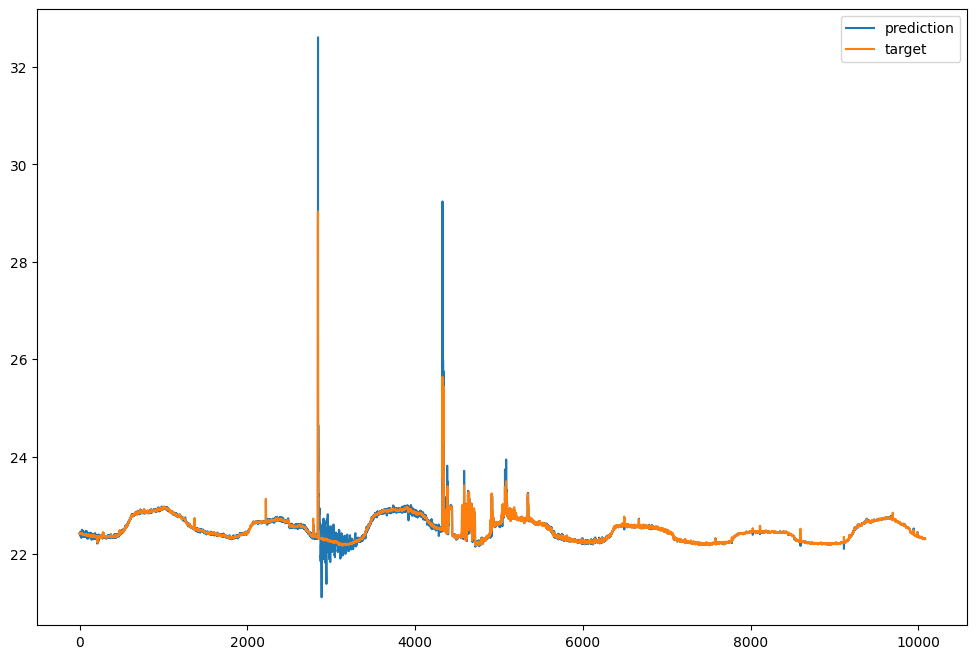

In [49]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [50]:
np.array(pred_list)

array([22.42112541, 22.40507317, 22.41697311, ..., 22.30247307,
       22.31955528, 22.3079586 ])

In [51]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [52]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [53]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 0.13146944111213088 %
RMSE 0.12964102625846863
MAPE 0.13195548672229052 %


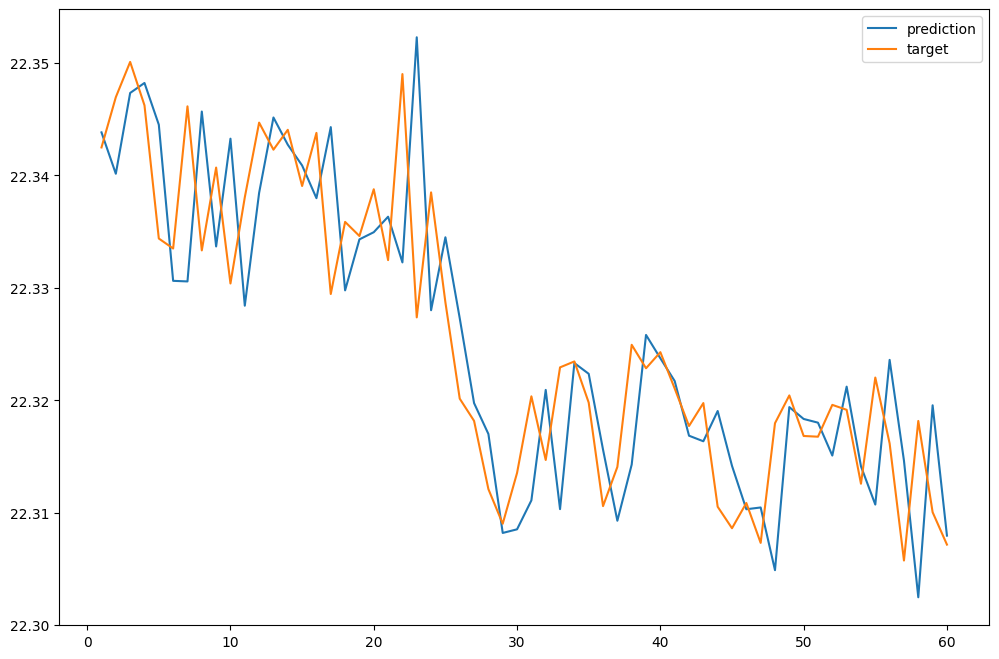

In [54]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [55]:
len(time_list)

10080

In [56]:
np.mean(time_list) 

0.4150358524350893